# Embeddings

## Overview

"An embedding is a special format of data representation that can be easily utilized by machine learning models and algorithms. The embedding is an information dense representation of the semantic meaning of a piece of text. Each embedding is a vector of floating-point numbers, such that the distance between two embeddings in the vector space is correlated with semantic similarity between two inputs in the original format. For example, if two texts are similar, then their vector representations should also be similar."

To find out more, see: https://learn.microsoft.com/en-us/azure/cognitive-services/openai/concepts/understand-embeddings

## Azure OpenAI Models

To create text embeddings, there are a number of models to choose from, with **each model generating a different set of embeddings as output**. This means that:
- embeddings created with one model cannot be compared to embeddings generated by another model
- the unique embeddings created by each model will have differing cosine distances between themselves -- ie. there is a distinction in how similar two elements of text are considered to be, depending upon the specific model chosen.

We will exhibit these "differing similarities" when we later measure the distance between embeddings within each model in the sections below.

### Model Taxonomy

**Model taxonomy**: {family} - {capability} - {input-type} - {identifier}  

{family}     --> text-similarity  (general text GPT-3 model)  
{capability} --> davincie         (curie is second most powerful in ada-babbage-curie-davinci family)  
{input-type} --> n/a              (only specified for search models)  
{identifier} --> 001              (version 001)

### Model Availability

Not all Azure OpenAI models are available in all Azure regions -- here are the text similarity models currently[^1] available to deploy, per Azure region

| Name | East US | South Central US | West Europe |
| --- | --- | --- | --- |
| `text-similarity-ada-001` | ✔ | ✔ | ✔ |
| `text-similarity-babbage-001` | ✘ | ✔ | ✔ |
| `text-similarity-curie-001` | ✔ | ✔ | ✔ |
| `text-similarity-davinci-001` | ✘ | ✔ | ✔ |

### Model Performance

We will test the performance of all the text similarity models currently[^1] offered in Azure OpenAI. Ensure you have all the required text similarity models deployed in order to run, or modify the `models_similarity` array to match your deployed models.

[^1]: Last updated 2023-Feb-06

### 1. Install dependencies

In [1]:
%pip install -q -r ../requirements.txt


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### 2. Import helper libraries, providing Azure endpoint location and API token

In [2]:
import os
import openai

openai.api_type = "azure"
openai.api_version = "2022-12-01"

API_KEY = os.getenv("AZURE_OPENAI_API_KEY","").strip()
assert API_KEY, "ERROR: Azure OpenAI Key is missing"
openai.api_key = API_KEY

RESOURCE_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT","").strip()
assert RESOURCE_ENDPOINT, "ERROR: Azure OpenAI Endpoint is missing"
assert "openai.azure.com" in RESOURCE_ENDPOINT.lower(), "ERROR: Azure OpenAI Endpoint should be in the form: \n\n\t<your unique endpoint identifier>.openai.azure.com"
openai.api_base = RESOURCE_ENDPOINT

### 3. Query the list of text similarity models that are deployed in your Azure endpoint

In [3]:
import json
import requests

url = openai.api_base + "/openai/deployments?api-version=2022-12-01"

json_data = requests.get(url, headers={"api-key": API_KEY}).text

data = json.loads(json_data)

models_similarity = []

print("Detected the following text-similarity models deployed at your Azure OpenAI endpoint:")

for item in data['data']:
    if "text-similarity" in item['model']:
        models_similarity.append(item['id'])
        print("Azure OpenAI Model: {}, your ID: {}".format(item['model'], item['id']))

"""
Complete list of models (where naming convention of model name = id)
models_similarity = [
        'text-similarity-ada-001',
        'text-similarity-babbage-001',
        'text-similarity-curie-001',
        'text-similarity-davinci-001'
]
"""

assert len(models_similarity), "ERROR: No text-similarity models found at your Azure endpoint, cannot proceed"

Detected the following text-similarity models deployed at your Azure OpenAI endpoint:
Azure OpenAI Model: text-similarity-ada-001, your ID: text-similarity-ada-001
Azure OpenAI Model: text-similarity-curie-001, your ID: text-similarity-curie-001


## Exercise 1: Simple Word Embeddings
We will test similarity of a number of words across the models deployed and see where they cluster within a scatterplot. As embeddings are high-dimensional non-linear representations, so we will first need to "flatten" those embeddings into two dimensions using a technique called [UMAP](https://umap.scikit-tda.org)

/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


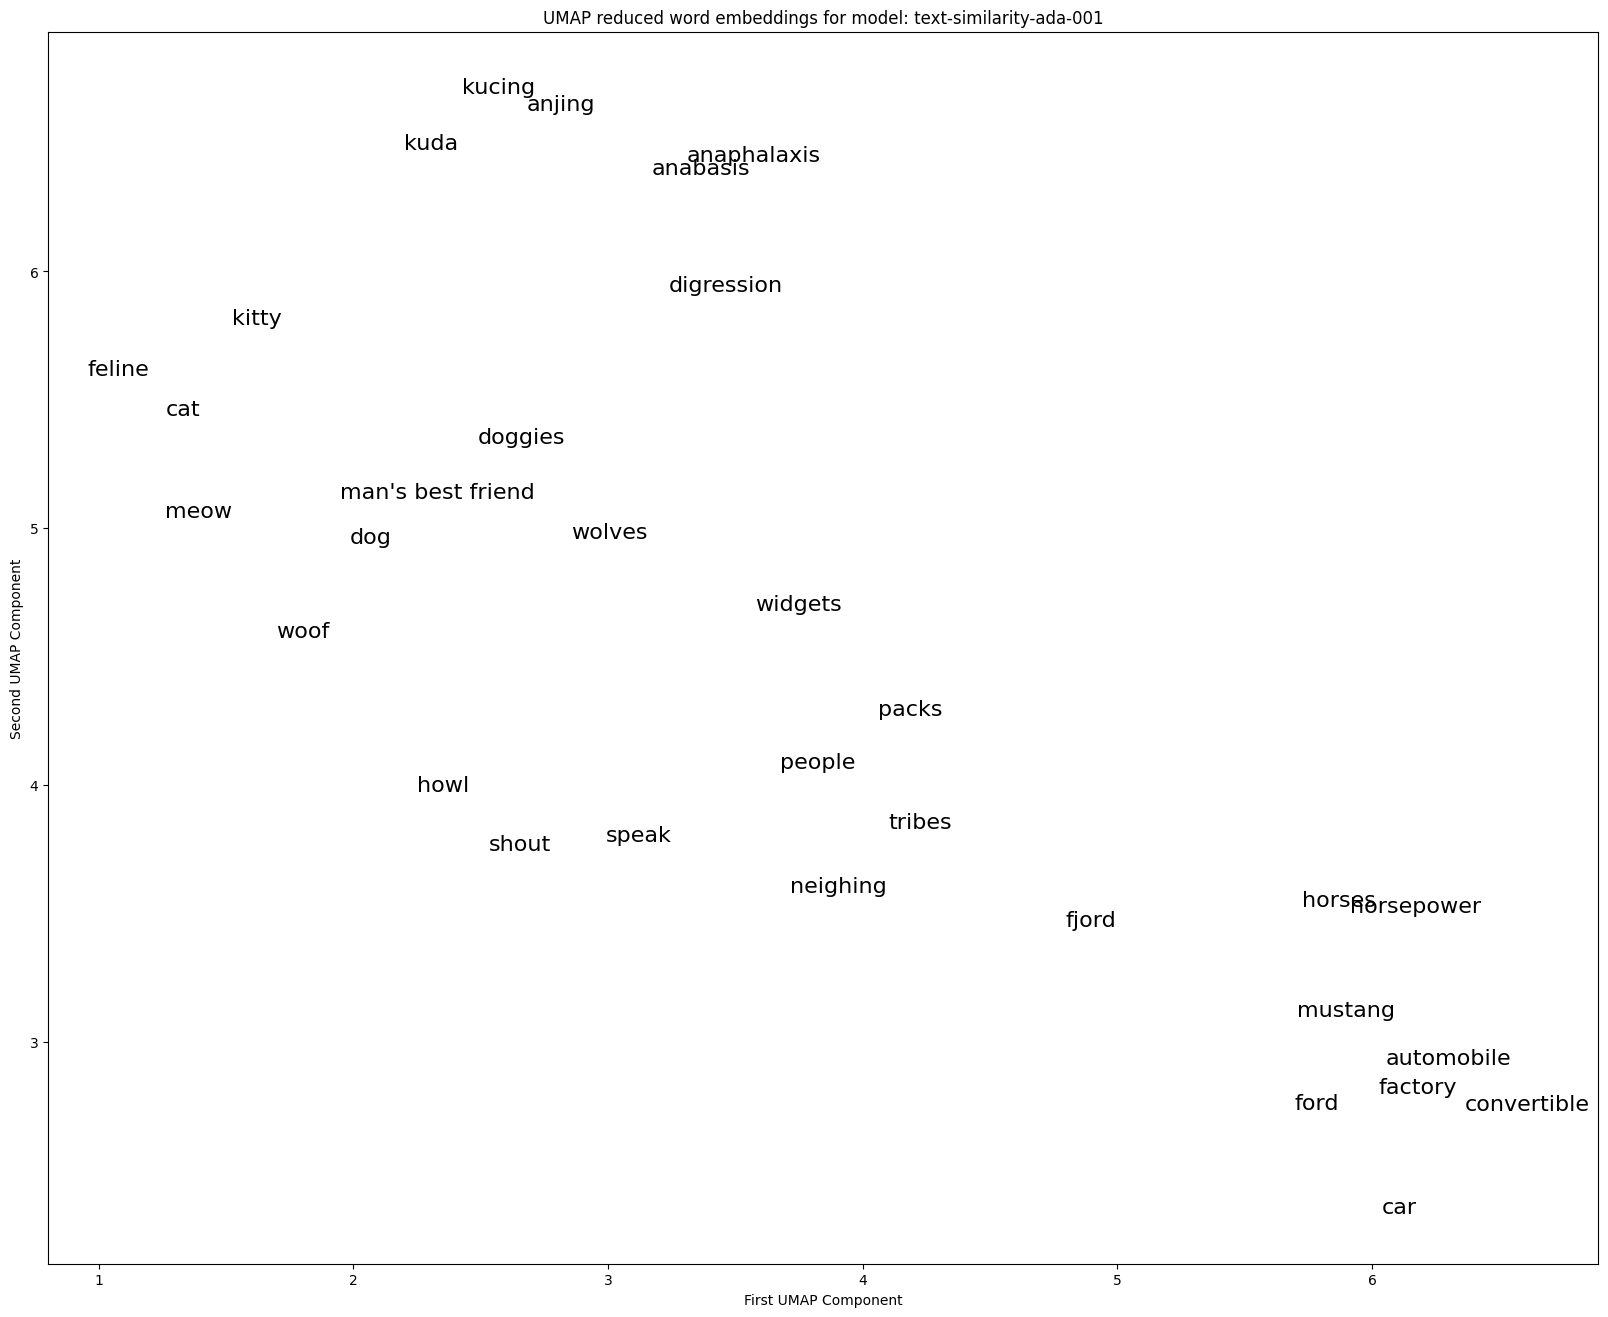

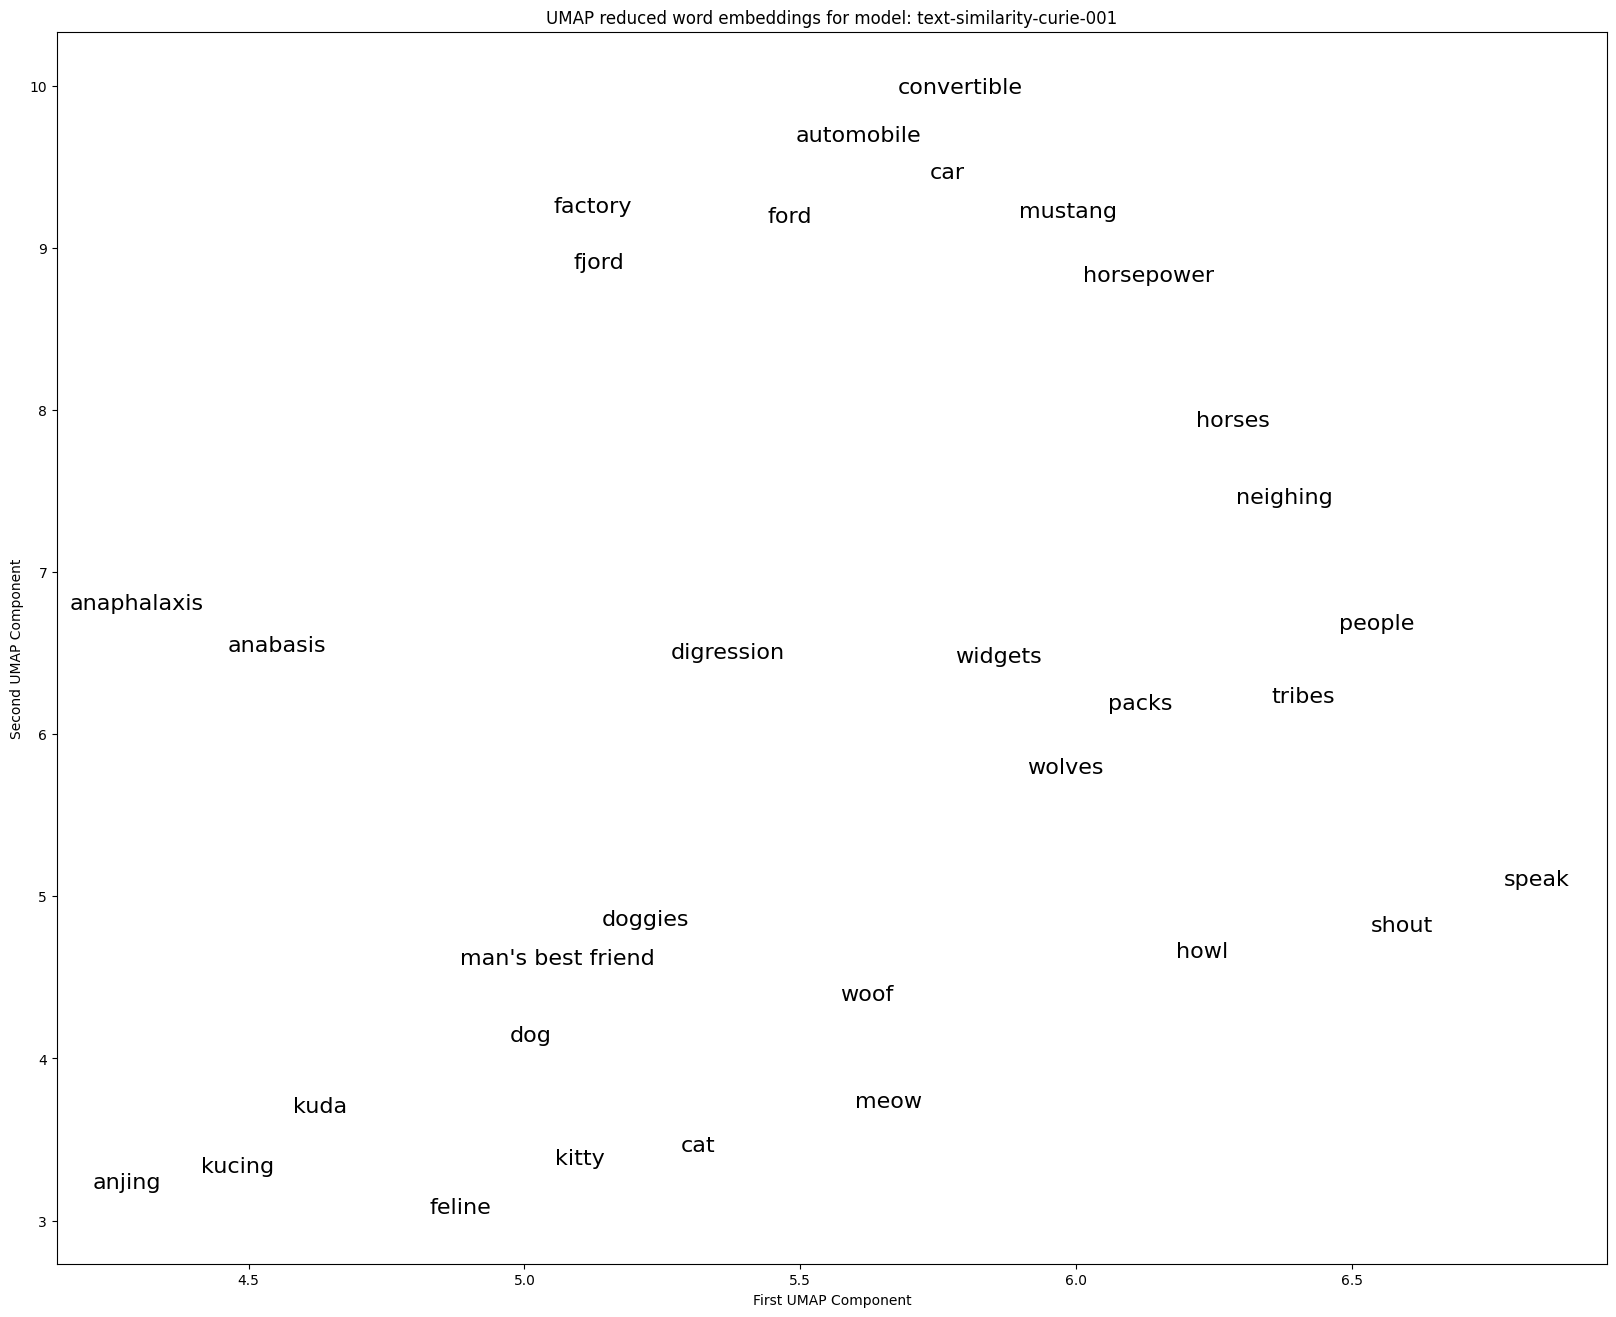

In [4]:
# compare a number of OpenAI models for measuring text similiarity as the dot-product of two tensors
# more info: https://openai.com/blog/introducing-text-and-code-embeddings

import plotly
import numpy as np
import plotly.graph_objs as go

import seaborn as sns
import matplotlib.pyplot as plt

def get_embeddings(source_text, model):
    return openai.Embedding.create(
            input=source_text,
            engine=model
)

tests = [
    "feline",
    "cat",
    "kitty",
    "meow",
    "doggies",
    "dog",
    "man's best friend",
    "woof",
    "people",
    "tribes",
    "wolves",
    "packs",
    "howl",
    "speak",
    "shout",
    "widgets",
    "factory",
    "fjord",
    "ford",
    "mustang",
    "convertible",
    "automobile",
    "car",
    "horsepower",
    "horses",
    "neighing",
    # Indonesian terms (cat, dog, horse respectively)
    "kucing",
    "anjing",
    "kuda",
    # completely random words
    "anaphalaxis",
    "anabasis",
    "digression"
]

results={}

import umap.umap_ as umap

for model in models_similarity:
    results[model]={}
    for test in tests:
        results[model][test] = get_embeddings(test, model)['data'][0]['embedding']
    
    # for more details on the specific hyperparameters chosen, see: https://umap.scikit-tda.org/parameters.html
    umap_model = umap.UMAP(n_neighbors=5, n_components=2, min_dist=0.05)
    umap_result = umap_model.fit_transform(np.array([results[model][test] for test in tests]))

    # generate interactive graph
    scatter_data = []
    for i, test in enumerate(tests):
        scatter_data.append(go.Scatter(x=[umap_result[i, 0]], y=[umap_result[i, 1]], mode='markers',
                                    name=test, text=test, marker=dict(size=15)))

    layout = go.Layout(title=f"UMAP reduced word embeddings for model: {model}", xaxis_title="First UMAP Dimension",
                    yaxis_title="Second UMAP Dimension")

    fig = go.Figure(data=scatter_data, layout=layout)
    plotly.offline.iplot(fig)

    # generate "word-cloud" graph
    plt.figure(figsize=(20, 16))
    sns.scatterplot(x=umap_result[:, 0], y=umap_result[:, 1], s=0, alpha=0, linewidth=0)
    plt.title(f"UMAP reduced word embeddings for model: {model}")
    plt.xlabel("First UMAP Component")
    plt.ylabel("Second UMAP Component")
    for i, test in enumerate(tests):
        plt.text(umap_result[i, 0], umap_result[i, 1], test, ha='center', va='center', fontsize=16)
    plt.show()

Next, we will measure the distance between those embeddings and create a heatmap to display the similarity of one word to another, with highest values (yellow/green areas) as "the words are closely related to each other" and lowest as "the words are dissimilar to each other".

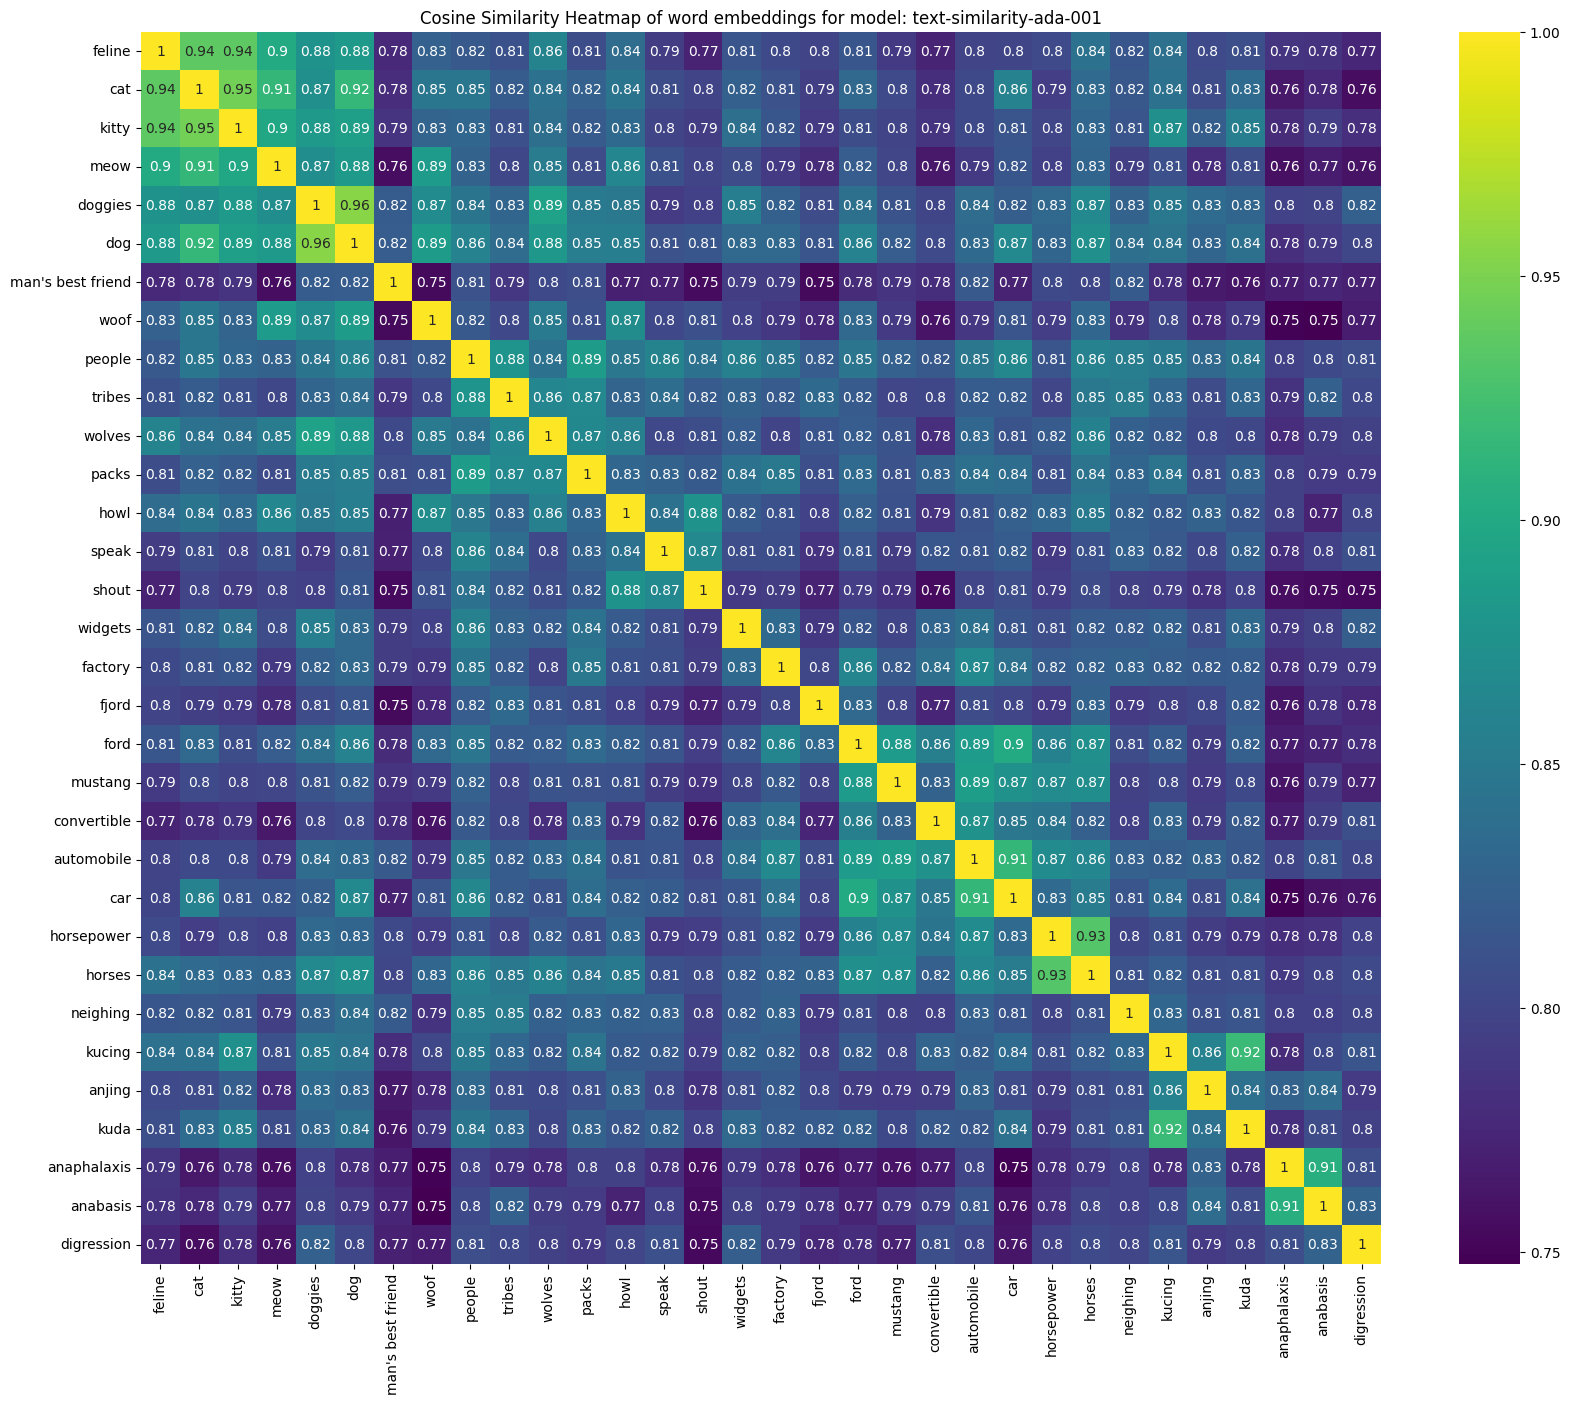

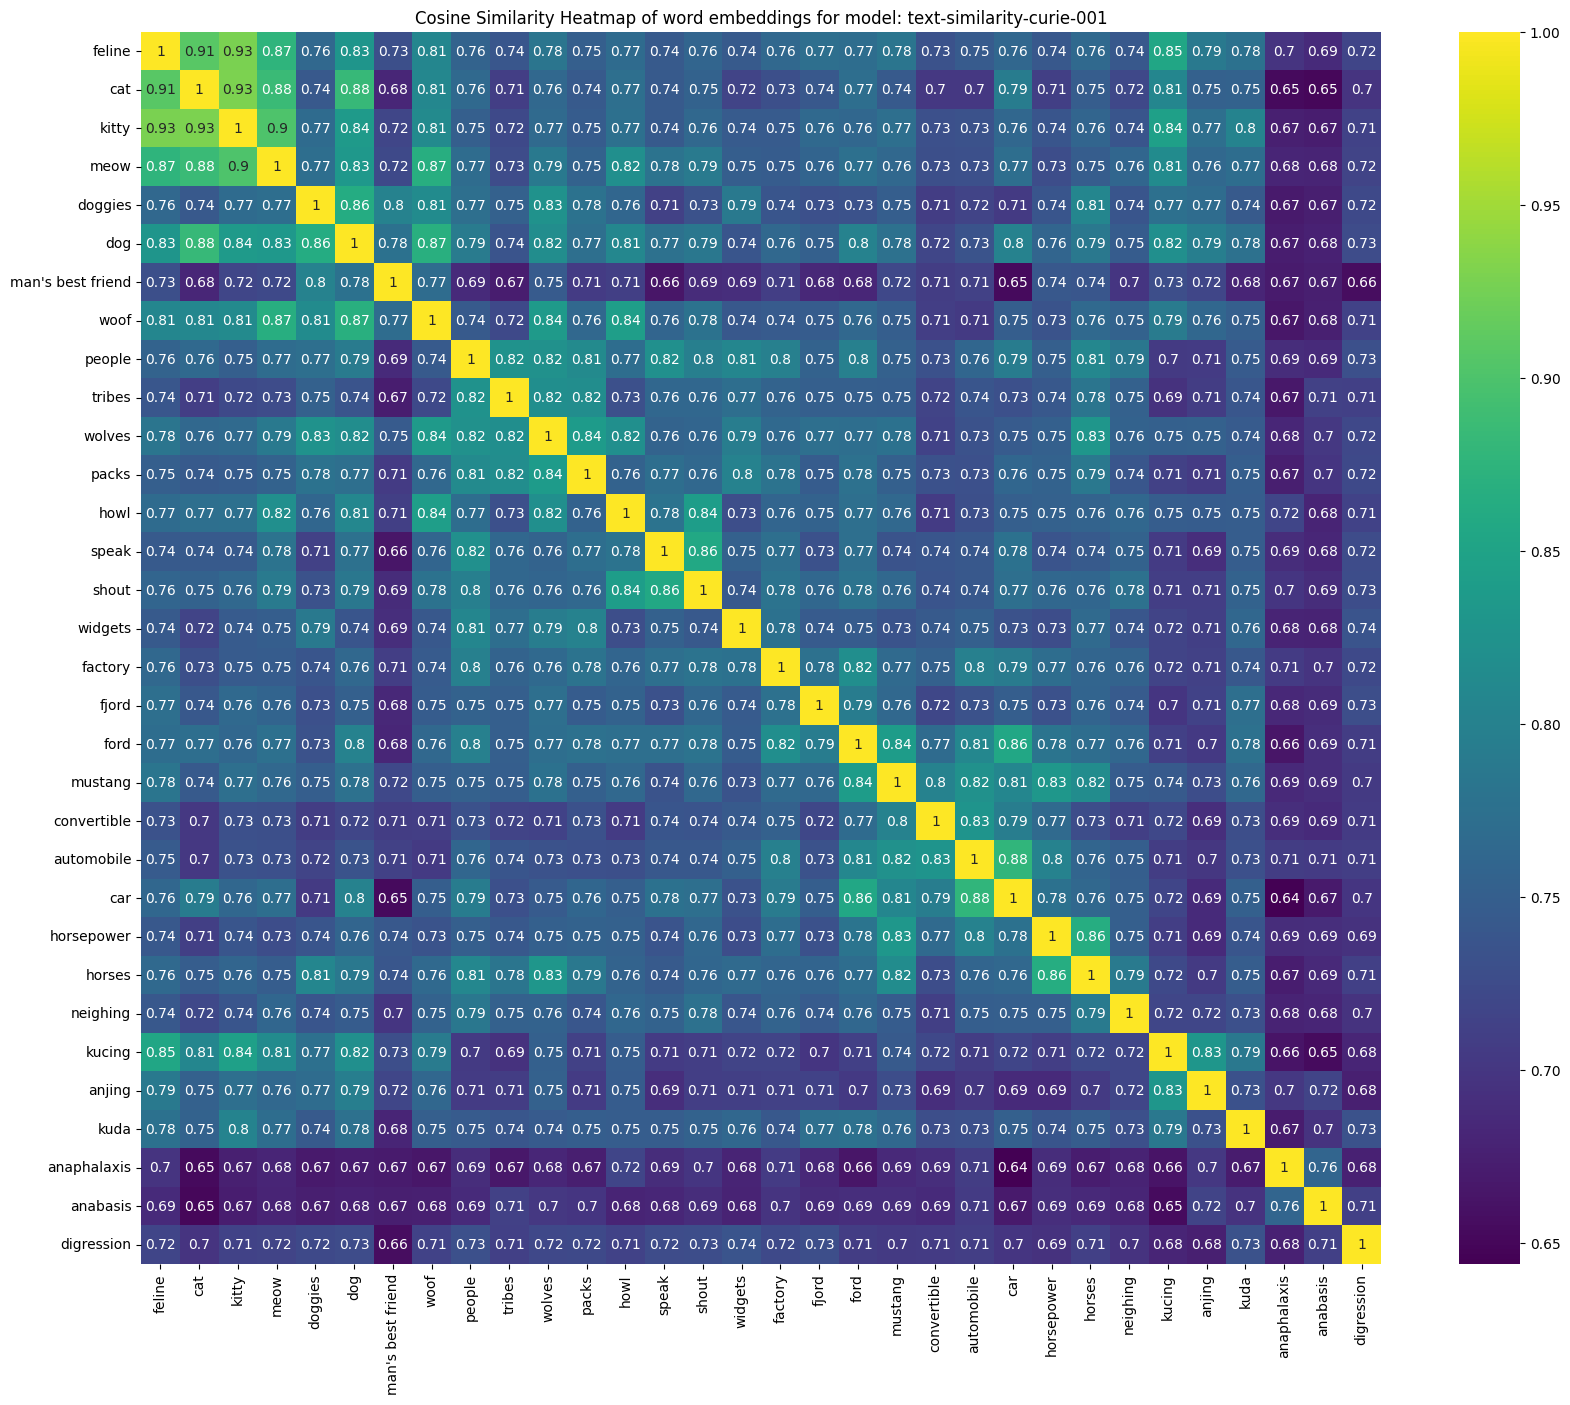

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt


def show_cosine_similarity_matrix(m, r):
    from openai.embeddings_utils import cosine_similarity

    cosine_similarity_matrix = np.zeros((len(r[m]), len(r[m])))

    for i, test_i in enumerate(r[m]):
        for j, test_j in enumerate(r[m]):
            cosine_similarity_matrix[i, j] = cosine_similarity(r[m][test_i], r[m][test_j])
    
    plt.figure(figsize=(20, 16))
    sns.heatmap(cosine_similarity_matrix, xticklabels=r[m], yticklabels=r[m], cmap='viridis', annot=True)
    plt.title(f"Cosine Similarity Heatmap of word embeddings for model: {m}")
    plt.show()

for model in models_similarity:    
    show_cosine_similarity_matrix(model, results)


## Embeddings Part 2: Document Embeddings

Next, we will compare full text documents for similarity. We will be using a public dataset from [HuggingFace](https://huggingface.co) called [CNN Daily News](https://huggingface.co/datasets/cnn_dailymail). From the Dataset card:

> The CNN / DailyMail Dataset is an English-language dataset containing just over 300k unique news articles as written by journalists at CNN and the Daily Mail. The current version supports both extractive and abstractive summarization, though the original version was created for machine reading and comprehension and abstractive question answering.

We will use that dataset by leveraging the HuggingFace [datasets](https://github.com/huggingface/datasets) library.

*PLEASE NOTE: the initial call to the .load_dataset() function will consume approx 1.3GB of local storage, subsequent runs will then leverage a locally cached copy of the dataset*

In [6]:
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail","3.0.0")

Found cached dataset cnn_dailymail (/home/codespace/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)
100%|██████████| 3/3 [00:11<00:00,  3.84s/it]


In [7]:
import pandas as pd

df = pd.DataFrame(dataset["train"][:10])
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   article     10 non-null     object
 1   highlights  10 non-null     object
 2   id          10 non-null     object
dtypes: object(3)
memory usage: 368.0+ bytes


In [8]:
for index, row in df.iterrows():
    print(f"{index}: {row['highlights']}")

0: Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday .
Young actor says he has no plans to fritter his cash away .
Radcliffe's earnings from first five Potter films have been held in trust fund .
1: Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .
2: NEW: "I thought I was going to die," driver says .
Man says pickup truck was folded in half; he just has cut on face .
Driver: "I probably had a 30-, 35-foot free fall"
Minnesota bridge collapsed during rush hour Wednesday .
3: Five small polyps found during procedure; "none worrisome," spokesman says .
President reclaims powers transferred to vice president .
Bush undergoes routine colonoscopy at Camp David .
4: NEW: NFL chief, Atlanta Falcons owner critical of Michael Vick's conduct .

In [9]:
# Generate embeddings for each text input and append as a new column
def get_embeddings_array(arr, model):
    embeddings = []
    for text in arr:
        embedding = get_embeddings(text, model)['data'][0]['embedding']
        embeddings.append(embedding)
    return np.array(embeddings)

df[f"highlights_array"] = df["highlights"].apply(lambda x: x.replace('.', '').split('\n'))
df = df.explode(f"highlights_array")
# change name of highlights_array column to highlight, which will be the field for the embeddings
df.rename(columns={"highlights_array": "highlight"}, inplace=True)
# drop the original highlights column
df.drop(columns=["highlights"], inplace=True)

# loop over each model
for model in models_similarity:
    # apply the get_embeddings function to each highlight
    df[f"embeddings_{model}"] = df[f"highlight"].apply(lambda x: get_embeddings_array(x, model))

df.info()
df.head()

KeyboardInterrupt: 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def show_cosine_similarity_matrix(model, df):
    m=f"embeddings_{model}"
    from openai.embeddings_utils import cosine_similarity

    cosine_similarity_matrix = np.zeros((len(df[m]), len(df[m])))

    for i, test_i in enumerate(df[m]):
        for j, test_j in enumerate(df[m]):
            cosine_similarity_matrix[i, j] = cosine_similarity(test_i, test_j)
    
    plt.figure(figsize=(20, 16))
    sns.heatmap(cosine_similarity_matrix, xticklabels=df["id"], yticklabels=df["id"], cmap='viridis', annot=True)
    plt.title(f"Cosine Similarity Heatmap of highlight text embeddings for model: {m}")
    plt.show()

for model in models_similarity:
    show_cosine_similarity_matrix(model, df)

In [ ]:
def generate_embeddings(text, model):
    # Generate text embeddings using GPT-3
    embeddings = model.encode(text, response_format="json")
    # Extract the embedding vector from the response
    embedding_vector = embeddings["choices"][0]["text"].strip().split("\n")
    embedding_vector = [float(x) for x in embedding_vector]
    # Return the embedding vector
    return embedding_vector

for model in models_similarity:
    get_embeddings(test, model)

In [ ]:
results={}

import umap.umap_ as umap

for model in models_similarity:
    results[model]={}
    for test in tests:
        results[model][test] = get_embeddings(test, model)['data'][0]['embedding']
    
    # for more details on the specific hyperparameters chosen, see: https://umap.scikit-tda.org/parameters.html
    umap_model = umap.UMAP(n_neighbors=5, n_components=2, min_dist=0.05)
    umap_result = umap_model.fit_transform(np.array([results[model][test] for test in tests]))

    # generate interactive graph
    scatter_data = []
    for i, test in enumerate(tests):
        scatter_data.append(go.Scatter(x=[umap_result[i, 0]], y=[umap_result[i, 1]], mode='markers',
                                    name=test, text=test, marker=dict(size=15)))

    layout = go.Layout(title=f"UMAP reduced word embeddings for model: {model}", xaxis_title="First UMAP Dimension",
                    yaxis_title="Second UMAP Dimension")

    fig = go.Figure(data=scatter_data, layout=layout)
    plotly.offline.iplot(fig)

    # generate "word-cloud" graph
    plt.figure(figsize=(20, 16))
    sns.scatterplot(x=umap_result[:, 0], y=umap_result[:, 1], s=0, alpha=0, linewidth=0)
    plt.title(f"UMAP reduced word embeddings for model: {model}")
    plt.xlabel("First UMAP Component")
    plt.ylabel("Second UMAP Component")
    for i, test in enumerate(tests):
        plt.text(umap_result[i, 0], umap_result[i, 1], test, ha='center', va='center', fontsize=16)
    plt.show()